In [1]:
import numpy as np


Device: cuda
Epoch 0: loss=-2.0447e-01 | Eint=3.6651e-02 | Eext=-2.4123e-01 | Req=1.1534e-01
Epoch 100: loss=-5.0007e-01 | Eint=4.9969e-01 | Eext=-9.9979e-01 | Req=3.0202e-02
Epoch 200: loss=-5.0016e-01 | Eint=5.0007e-01 | Eext=-1.0003e+00 | Req=2.1596e-02
Epoch 300: loss=-5.0018e-01 | Eint=5.0014e-01 | Eext=-1.0003e+00 | Req=2.1226e-02
Epoch 400: loss=-5.0019e-01 | Eint=5.0016e-01 | Eext=-1.0004e+00 | Req=2.1260e-02


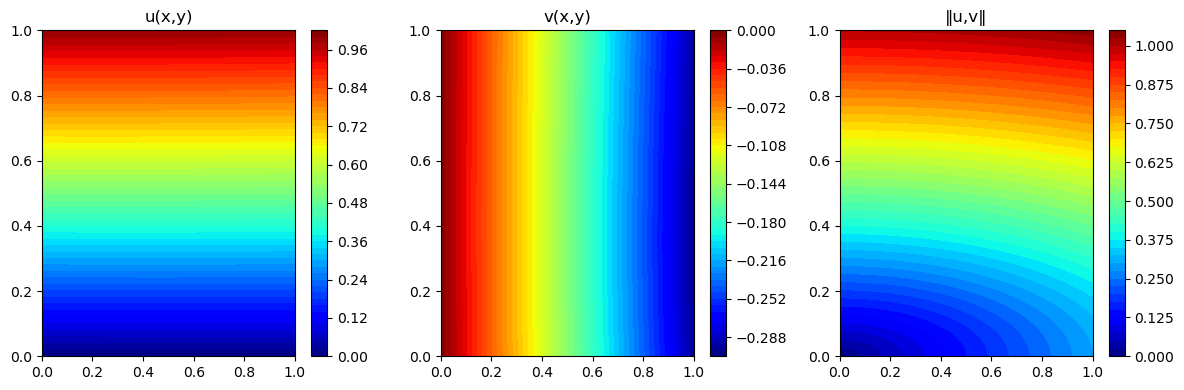

In [ ]:
# ============================================================
# 1. Device setup
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

manualSeed = 1234
torch.manual_seed(manualSeed)
np.random.seed(manualSeed)
random.seed(manualSeed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(manualSeed)

# ============================================================
# 2. Neural network definition
# ============================================================
class Net2D(nn.Module):
    def __init__(self, n_input=2, n_output=2, n_layer=8, n_nodes=80):
        super().__init__()
        self.input = nn.Linear(n_input, n_nodes)
        self.hidden = nn.ModuleList([nn.Linear(n_nodes, n_nodes) for _ in range(n_layer)])
        self.output = nn.Linear(n_nodes, n_output)
        for L in [self.input, self.output] + list(self.hidden):
            nn.init.xavier_uniform_(L.weight)
            nn.init.normal_(L.bias, std=1e-3)
        self.act = torch.sin

    def forward(self, x):
        y = self.act(self.input(x))
        for L in self.hidden:
            y = self.act(L(y))
        return self.output(y)

# ============================================================
# 3. Domain definition
# ============================================================
nelx, nely = 100, 100
xs = np.linspace(0.0, 1.0, nelx + 1)
ys = np.linspace(0.0, 1.0, nely + 1)
X, Y = np.meshgrid(xs, ys)
pts = np.hstack([X.reshape(-1, 1, order='F'), Y.reshape(-1, 1, order='F')])
N_total = pts.shape[0]
data = torch.tensor(pts, dtype=torch.float32, device=device, requires_grad=True)

# Boundary indices
tol = 1e-6
right_idx = np.where(np.abs(pts[:, 0] - 1.0) < tol)[0]  # x=1 traction
top_idx   = np.where(np.abs(pts[:, 1] - 1.0) < tol)[0]  # y=1 free
right_idx_t = torch.tensor(right_idx, dtype=torch.long, device=device)
top_idx_t   = torch.tensor(top_idx, dtype=torch.long, device=device)

# ============================================================
# 4. Material properties
# ============================================================
E = 1.0
nu = 0.3
T = 1.0
E_node = torch.ones((N_total, 1), device=device) * E

# ============================================================
# 5. Network and BC embedding
# ============================================================
net_uv = Net2D().to(device)

def uv_tilde(pt):
    """Hard BCs: u(x=0)=0, v(y=0)=0"""
    x = pt[:, 0:1]
    y = pt[:, 1:2]
    uv = net_uv(pt)
    u = x * uv[:, 0:1]         # u = 0 at x=0
    v = y * uv[:, 1:2]         # v = 0 at y=0
    return torch.cat([u, v], dim=1)

# ============================================================
# 6. Loss: total energy + equilibrium residual
# ============================================================
def energy_equilibrium_loss():
    uv = uv_tilde(data)
    u, v = uv[:, 0:1], uv[:, 1:2]

    du = torch.autograd.grad(u, data, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    dv = torch.autograd.grad(v, data, torch.ones_like(v), retain_graph=True, create_graph=True)[0]
    du_x, du_y = du[:, 0:1], du[:, 1:2]
    dv_x, dv_y = dv[:, 0:1], dv[:, 1:2]

    # Strains
    ex = du_x
    ey = dv_y
    gamma_xy = du_y + dv_x

    # Constitutive law (plane stress)
    G = E_node / (2 * (1 + nu))
    lam = E_node * nu / (1 - nu**2)
    sx = 2 * G * ex + lam * (ex + ey)
    sy = 2 * G * ey + lam * (ex + ey)
    txy = G * gamma_xy

    # Internal energy
    w_density = 0.5 * (sx * ex + sy * ey + txy * gamma_xy)
    Eint = torch.mean(w_density)

    # External work (traction on x=1)
    u_right = u[right_idx_t]
    Eext = -T * torch.mean(u_right)

    # Equilibrium residual (for regularization)
    dsx_dx = torch.autograd.grad(sx, data, torch.ones_like(sx), retain_graph=True, create_graph=True)[0][:, 0:1]
    dsy_dy = torch.autograd.grad(sy, data, torch.ones_like(sy), retain_graph=True, create_graph=True)[0][:, 1:1+1]
    dtxy_dx = torch.autograd.grad(txy, data, torch.ones_like(txy), retain_graph=True, create_graph=True)[0][:, 0:1]
    dtxy_dy = torch.autograd.grad(txy, data, torch.ones_like(txy), retain_graph=True, create_graph=True)[0][:, 1:1+1]
    rx = dsx_dx + dtxy_dy
    ry = dtxy_dx + dsy_dy
    R_eq = torch.mean(rx**2 + ry**2)

    loss = Eint + Eext + 1e-3 * R_eq
    return loss, Eint, Eext, R_eq

# ============================================================
# 7. Training: Adam + L-BFGS
# ============================================================
optimizer = torch.optim.Adam(net_uv.parameters(), lr=1e-3)
epochs = 500
for ep in range(epochs):
    optimizer.zero_grad()
    loss, Eint, Eext, R_eq = energy_equilibrium_loss()
    loss.backward()
    optimizer.step()
    if ep % 100 == 0:
        print(f"Epoch {ep}: loss={loss.item():.4e} | Eint={Eint.item():.4e} | Eext={Eext.item():.4e} | Req={R_eq.item():.4e}")




L2 error in u: 4.143e-01, L2 error in v: 1.241e-01


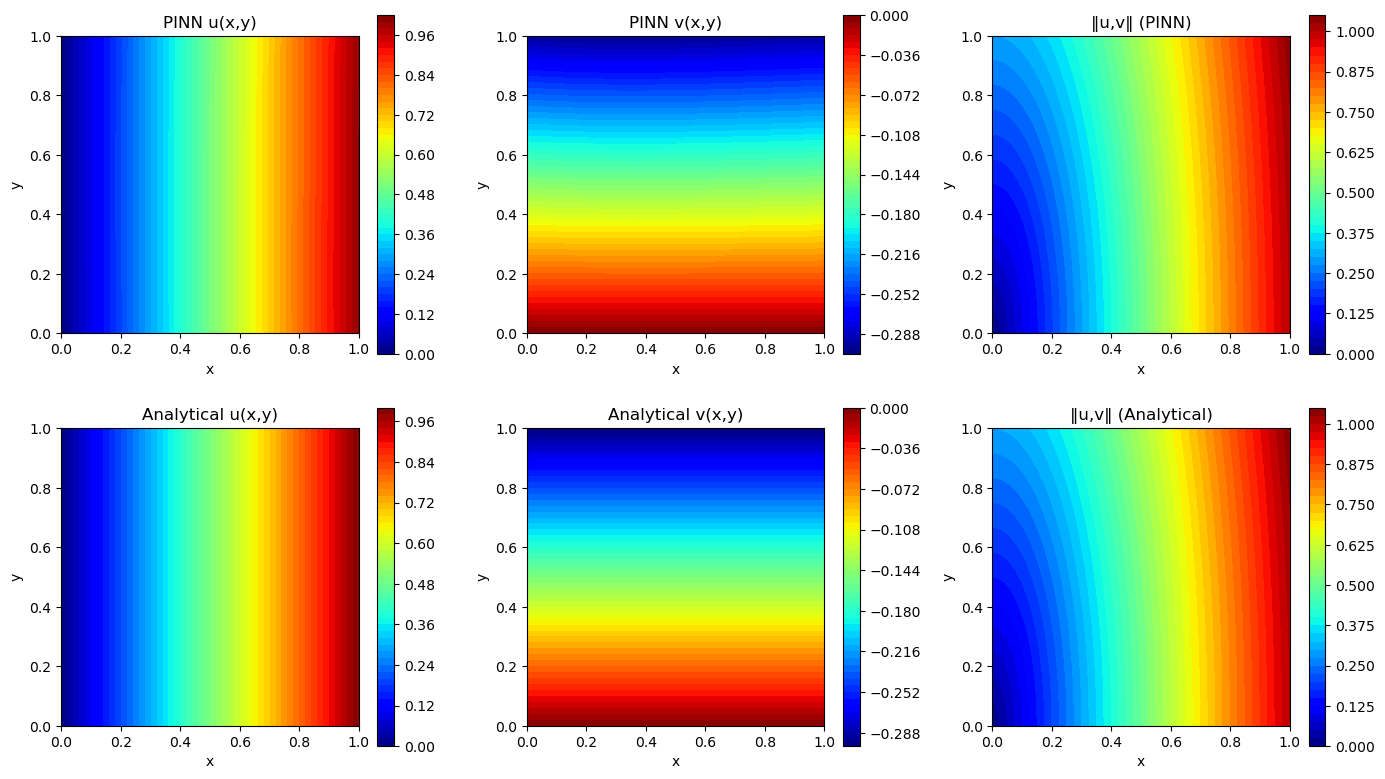

In [5]:
# ============================================================
# 8. Postprocessing + Analytical Comparison
# ============================================================
net_uv.eval()
with torch.no_grad():
    uv_pred = uv_tilde(data).cpu().numpy()
u_np = uv_pred[:, 0].reshape((nely + 1, nelx + 1), order='F')
v_np = uv_pred[:, 1].reshape((nely + 1, nelx + 1), order='F')

x = np.linspace(0, 1, nelx + 1)
y = np.linspace(0, 1, nely + 1)
X, Y = np.meshgrid(x, y)

# --- Analytical solution ---
u_analytic = (T / E) * X
v_analytic = -(nu * T / E) * Y

# --- Compute errors ---
err_u = np.abs(u_np.T - u_analytic)
err_v = np.abs(v_np.T - v_analytic)
L2_u = np.sqrt(np.mean(err_u**2))
L2_v = np.sqrt(np.mean(err_v**2))
print(f"L2 error in u: {L2_u:.3e}, L2 error in v: {L2_v:.3e}")

# --- Plot results ---
fig, axs = plt.subplots(2, 3, figsize=(14, 8))

# PINN
cf1 = axs[0, 0].contourf(X, Y, u_np, 50, cmap='jet')
axs[0, 0].set_title("PINN u(x,y)")
plt.colorbar(cf1, ax=axs[0, 0])

cf2 = axs[0, 1].contourf(X, Y, v_np, 50, cmap='jet')
axs[0, 1].set_title("PINN v(x,y)")
plt.colorbar(cf2, ax=axs[0, 1])

norm_uv = np.sqrt(u_np**2 + v_np**2)
cf3 = axs[0, 2].contourf(X, Y, norm_uv, 50, cmap='jet')
axs[0, 2].set_title("‖u,v‖ (PINN)")
plt.colorbar(cf3, ax=axs[0, 2])

# Analytical
cf4 = axs[1, 0].contourf(X, Y, u_analytic, 50, cmap='jet')
axs[1, 0].set_title("Analytical u(x,y)")
plt.colorbar(cf4, ax=axs[1, 0])

cf5 = axs[1, 1].contourf(X, Y, v_analytic, 50, cmap='jet')
axs[1, 1].set_title("Analytical v(x,y)")
plt.colorbar(cf5, ax=axs[1, 1])

norm_analytic = np.sqrt(u_analytic**2 + v_analytic**2)
cf6 = axs[1, 2].contourf(X, Y, norm_analytic, 50, cmap='jet')
axs[1, 2].set_title("‖u,v‖ (Analytical)")
plt.colorbar(cf6, ax=axs[1, 2])

for ax_row in axs:
    for ax in ax_row:
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_aspect("equal")

plt.tight_layout()
plt.show()
